In [6]:
%load_ext autoreload
%autoreload 2

import os
if not os.getcwd().endswith('BENDR'): os.chdir(os.path.dirname(os.getcwd()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from tqdm import tqdm

import BENDR.utils as utils
from importlib import reload
import BENDR.BENDR_utils as BENDR_utils
reload(BENDR_utils)
from BENDR.BENDR_utils import FullBENDR, LinearBENDR
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import mne

from dn3.configuratron import ExperimentConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_raw(edf_file_path):
    # Read the EDF file and load the data into a Raw object
    raw = mne.io.read_raw_edf(edf_file_path, verbose=False, preload=True)

    # Standardize channel names according to the EEGBCI dataset
    mne.datasets.eegbci.standardize(raw)

    # Create a standard 10-20 montage
    montage = mne.channels.make_standard_montage('standard_1020')

    # Rename channels, removing dots and capitalizing names, with some specific adjustments
    new_names = {
        ch_name: ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp')
        for ch_name in raw.ch_names
    }
    raw.rename_channels(new_names)

    # Set average reference for EEG channels and apply the montage
    raw.set_eeg_reference(ref_channels='average', projection=True, verbose=False)
    raw.set_montage(montage)

    # Apply projection to the data
    raw.apply_proj(verbose=False)

    # Rename P7 and P8 channels to T5 and T6, if present
    if 'P7' in raw.ch_names:
        raw.rename_channels({'P7': 'T5'})
    if 'P8' in raw.ch_names:
        raw.rename_channels({'P8': 'T6'})

    # Remove dots from channel names and capitalize them
    new_names = {ch_name: ch_name.rstrip('.').upper() for ch_name in raw.ch_names}
    raw.rename_channels(new_names)

    # Resample the data to 256 Hz
    raw.resample(256)

    # Apply bandpass filter between 0.1 and 100 Hz
    raw.filter(0.1, 100, verbose=False)

    # Apply notch filter at 60 Hz
    raw.notch_filter(60, verbose=False)

    return raw

In [3]:
experiment = ExperimentConfig("configs/downstream.yml")
data = experiment.datasets["mmidb"]
data.add_custom_raw_loader(get_raw)
ds_name, ds = list(experiment.datasets.items())[0]

Adding additional configuration entries: dict_keys(['train_params', 'lr', 'folds'])
Configuratron found 1 datasets.


In [8]:
gen = utils.get_lmoso_iterator(ds_name, ds)
training, validation, test = next(gen)
x_train, y_train = map(torch.Tensor, training.to_numpy())
x_val, y_val = map(torch.Tensor, validation.to_numpy())
x_test, y_test = map(torch.Tensor, test.to_numpy())

Scanning data/datasets/eegmmidb. If there are a lot of files, this may take a while...: 100%|██████████| 4/4 [00:00<00:00, 18.27it/s, extension=.gdf]


Creating dataset of 315 Preloaded Epoched recordings from 105 people.


Loading Physionet MMIDB: 100%|██████████| 105/105 [02:19<00:00,  1.33s/person]


>> Physionet MMIDB | DSID: None | 105 people | 4722 trials | 90 channels | 1024 samples/trial | 256.0Hz | 0 transforms
Constructed 1 channel maps
Used by 315 recordings:
EEG (original(new)): FC5(FC5) FC3(FC3) FC1(FC1) FCZ(FCZ) FC2(FC2) FC4(FC4) FC6(FC6) C5(C5) C3(C3) C1(C1) CZ(CZ) C2(C2) C4(C4) C6(C6) CP5(CP5) CP3(CP3) CP1(CP1) CPZ(CPZ) CP2(CP2) CP4(CP4) CP6(CP6) FP1(FP1) FPZ(FPZ) FP2(FP2) AF7(AF7) AF3(AF3) AFZ(AFZ) AF4(AF4) AF8(AF8) F7(F7) F5(F5) F3(F3) F1(F1) FZ(FZ) F2(F2) F4(F4) F6(F6) F8(F8) FT7(FT7) FT8(FT8) T7(T7) T8(T8) T9(T9) T10(T10) TP7(TP7) TP8(TP8) T5(T5) P5(P5) P3(P3) P1(P1) PZ(PZ) P2(P2) P4(P4) P6(P6) T6(T6) PO7(PO7) PO3(PO3) POZ(POZ) PO4(PO4) PO8(PO8) O1(O1) OZ(OZ) O2(O2) IZ(IZ) 
EOG (original(new)): 
REF (original(new)): 
EXTRA (original(new)): 
Heuristically Assigned: 
--------------------
Excluded []
Training:   >> Physionet MMIDB | DSID: None | 103 people | 4632 trials | 20 channels | 1024 samples/trial | 256.0Hz | 1 transforms
Validation: Person S109 - 45 trials | 1

Loading Batches: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


In [9]:
encoder_weights = 'data/checkpoints/encoder_BENDR_linear_2_1024_20.pt'
enc_augment_weights = 'data/checkpoints/enc_augment_BENDR_linear_2_1024_20.pt'
classifier_weights = 'data/checkpoints/classifier_BENDR_linear_2_1024_20.pt'
extended_classifier_weights = 'data/checkpoints/extended_classifier_BENDR_linear_2_1024_20.pt'

model = LinearBENDR(targets=2, samples=1024, channels=20, device='cpu')
model.load_all(encoder_weights, enc_augment_weights, classifier_weights, extended_classifier_weights)
model = model.train(False)

Receptive field: 143 samples | Downsampled by 96 | Overlap of 47 samples | 10 encoded samples/trial | 4 pooled


In [6]:
pred_test = model.evaluate(x_test)
print(torch.mean((pred_test == y_test).type(torch.float)))

Evaluating: 100%|██████████| 6/6 [00:00<00:00, 57.86batches/s]

tensor(0.8000)


In [8]:
pred_val = model.evaluate(x_val)
print(torch.mean((pred_val == y_val).type(torch.float)))

Evaluating: 100%|██████████| 29/29 [00:00<00:00, 85.28batches/s]

tensor(0.8311)


In [9]:
pred_train = model.evaluate(x_train)
print(torch.mean((pred_train == y_train).type(torch.float)))

Evaluating: 100%|██████████| 534/534 [00:05<00:00, 104.73batches/s]

tensor(0.9328)


In [ ]:
features_test = torch.empty(len(x_test), 512)
probs_test = torch.empty(len(x_test), 2)
for i in tqdm(range(len(x_test))):
    probs_test[i], features_test[i] = model.feedforward_probs(x_test[i], return_features=True)

100%|██████████| 882/882 [00:33<00:00, 26.61it/s]


In [ ]:
features_test = torch.empty(len(x_test), 512)
probs_test = torch.empty(len(x_test), 2)
for i in tqdm(range(len(x_test))):
    probs_test[i], features_test[i] = model.feedforward_probs(x_test[i], return_features=True)

100%|██████████| 882/882 [00:32<00:00, 27.13it/s]


In [ ]:
for child in model.children():
    print(child)
    print()
    print('-' * 80)
    print()

Sequential(
  (0): Flatten()
  (1): Linear(in_features=512, out_features=2, bias=True)
)

--------------------------------------------------------------------------------

ConvEncoderBENDR(
  (encoder): Sequential(
    (Encoder_0): Sequential(
      (0): Conv1d(20, 512, kernel_size=(3,), stride=(3,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (Encoder_1): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (Encoder_2): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (Encoder_3): Sequential(
      (0): Conv1d(512, 512, ker

In [9]:
from collections import defaultdict
class SaveOutput:
    def __init__(self):
        self.outputs = defaultdict(list)
        
    def __call__(self, module, module_in, module_out):
        self.outputs[module].append(module_out.detach().cpu().numpy())
        
    def clear(self):
        self.outputs = []

In [10]:
save_output = SaveOutput()
hook_handles = []
for layer in model.contextualizer.modules():
    if isinstance(layer, torch.nn.modules.transformer.TransformerEncoderLayer):
        handle = layer.linear1.register_forward_hook(save_output)
        hook_handles.append(handle)
        break

for i in tqdm(range(len(x_train))):
    model.feedforward_probs(x_train[i])

100%|██████████| 2646/2646 [01:53<00:00, 23.37it/s]


In [11]:
# Get first (key, value) of dictionary without using list
layer_name, layer_output = next(iter(save_output.outputs.items()))

In [12]:
layer_output = np.concatenate([layer[0] for layer in layer_output])
#layer_output = layer_output.reshape(layer_output.shape[0], -1)

In [21]:
# Visualize latent space with umap
from umap import UMAP
import umap.plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

ModuleNotFoundError: No module named 'umap'

In [22]:
# Visualize latent space with t-SNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(layer_output)

umap = UMAP(n_components=2)
umap_results = umap.transform(layer_output)

NameError: name 'TSNE' is not defined

In [11]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(*umap_results.T, c=y_train, cmap='jet')
ax[1].scatter(*tsne_results.T, c=y_train, cmap='jet')
plt.show()

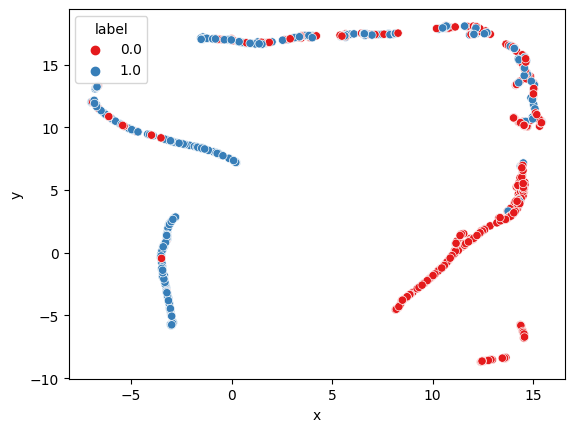

In [24]:


df = pd.DataFrame(embedding, columns=['x', 'y'])
df['label'] = y_test
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='Set1')
plt.show()


In [55]:
pca = PCA(n_components=2).fit(features_train)
X = pca.transform(features_test)

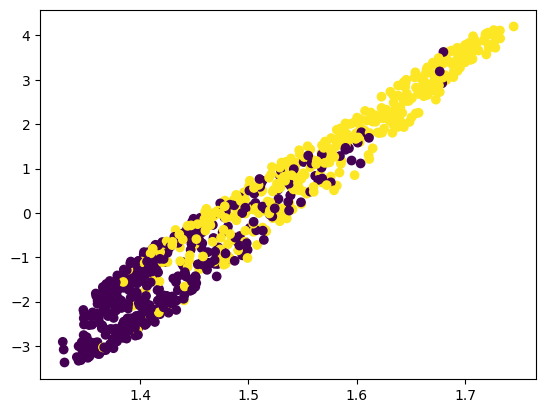

In [60]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*X.T, c=y_test)
plt.show()

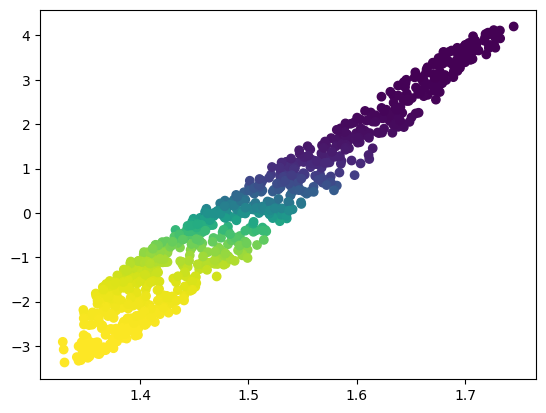

In [61]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*X.T, c=probs_test[:, 0])
plt.show()

# Data

In [ ]:
#added_metrics, retain_best, _ = utils.get_ds_added_metrics(ds_name, 'configs/metrics.yml')